## SetUp

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Load your datasets
complaints_df = pd.read_csv("BIC_Complaints_Inquiries_20250612.csv")
violations_df = pd.read_csv("BIC_Issued_Violations_20250612.csv")

# Optional: Set a consistent style
sns.set(style="whitegrid")

In [2]:
print("Complaints Summary:")
print(complaints_df.describe(include='all'))

print("\nViolations Summary:")
print(violations_df.describe(include='all'))

Complaints Summary:
       COMPLAINT/INQUIRY NUMBER LICENSE TYPE  \
count                     18542         2430   
unique                    18542            5   
top                  2012-00220  Trade Waste   
freq                          1         2160   
mean                        NaN          NaN   
std                         NaN          NaN   
min                         NaN          NaN   
25%                         NaN          NaN   
50%                         NaN          NaN   
75%                         NaN          NaN   
max                         NaN          NaN   

                                      ACCOUNT NAME BIC NUMBER  \
count                                         5490      12640   
unique                                         925       1193   
top     ACTION CARTING ENVIRONMENTAL SERVICES INC.    TWC-NaN   
freq                                           552       6057   
mean                                           NaN        NaN   
std          

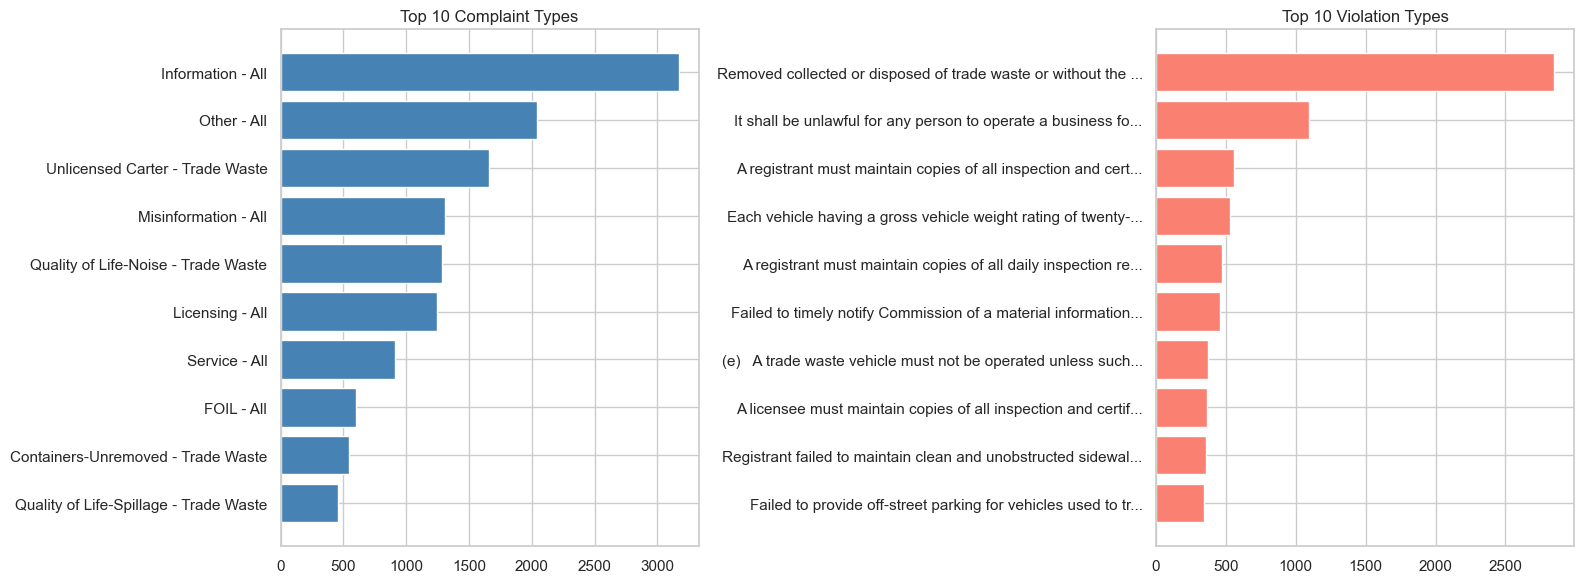

In [5]:
# Get top 10 types
complaint_types = complaints_df['NATURE OF COMPLAINT/INQUIRY'].value_counts().head(10)
violation_types = violations_df['DESCRIPTION OF RULE'].value_counts().head(10)

# Truncate for readability
truncated_violation_labels = [label[:60] + '...' if len(label) > 60 else label for label in violation_types.index]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Complaints
ax[0].barh(complaint_types.index, complaint_types.values, color='steelblue')
ax[0].set_title("Top 10 Complaint Types")
ax[0].invert_yaxis()

# Violations (truncated)
ax[1].barh(truncated_violation_labels, violation_types.values, color='salmon')
ax[1].set_title("Top 10 Violation Types")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [19]:
# Convert date columns to datetime
complaints_df['Reported Date'] = pd.to_datetime(complaints_df['DATE COMPLAINT/INQUIRY REPORTED ON'], errors='coerce')
violations_df['Issued Date'] = pd.to_datetime(violations_df['DATE VIOLATION ISSUED'], errors='coerce')

# Extract year
complaints_df['Year'] = complaints_df['Reported Date'].dt.year
violations_df['Year'] = violations_df['Issued Date'].dt.year

# Count totals by year
complaints_yearly_totals = complaints_df['Year'].value_counts().sort_index().rename("Complaints")
violations_yearly_totals = violations_df['Year'].value_counts().sort_index().rename("Violations")

# Combine into a single DataFrame
yearly_totals = pd.concat([complaints_yearly_totals, violations_yearly_totals], axis=1).fillna(0).astype(int)
yearly_totals['Total Complaints and Violations'] = (
    yearly_totals['Complaints'] + yearly_totals['Violations']
)

# Display
from IPython.display import display
display(yearly_totals)


,Complaints,Violations,Total Complaints and Violations
Year,,,
2006.0,8,30,38
2007.0,1,41,42
2008.0,5,155,160
2009.0,10,231,241
2010.0,7,271,278
2011.0,4,155,159
2012.0,1,257,258
2013.0,238,170,408
2014.0,1226,742,1968


In [22]:
# Ensure Year is integer
complaints_df['Year'] = complaints_df['Year'].astype('Int64')
violations_df['Year'] = violations_df['Year'].astype('Int64')

# Get all years present in either set
all_years = sorted(set(complaints_df['Year'].dropna()) | set(violations_df['Year'].dropna()))

# Compute value counts
complaints_yearly = complaints_df['Year'].value_counts().rename("Complaints")
violations_yearly = violations_df['Year'].value_counts().rename("Violations")

# Combine into table
yearly_totals = pd.concat([complaints_yearly, violations_yearly], axis=1)

# Reindex to all years and sort
yearly_totals = yearly_totals.reindex(all_years).fillna(0).astype(int)

# Add total column
yearly_totals['Total Complaints and Violations'] = (
    yearly_totals['Complaints'] + yearly_totals['Violations']
)

print(yearly_totals)


      Complaints  Violations  Total Complaints and Violations
Year                                                         
2002           0           7                                7
2003           0          24                               24
2004           0           5                                5
2005           0          24                               24
2006           8          30                               38
2007           1          41                               42
2008           5         155                              160
2009          10         231                              241
2010           7         271                              278
2011           4         155                              159
2012           1         257                              258
2013         238         170                              408
2014        1226         742                             1968
2015        1083         891                             1974
2016    

In [10]:
# Convert date columns to datetime
complaints_df['Reported Date'] = pd.to_datetime(complaints_df['DATE COMPLAINT/INQUIRY REPORTED ON'], errors='coerce')
violations_df['Issued Date'] = pd.to_datetime(violations_df['DATE VIOLATION ISSUED'], errors='coerce')

# Extract year from dates
complaints_df['Year'] = complaints_df['Reported Date'].dt.year
violations_df['Year'] = violations_df['Issued Date'].dt.year

# Group by account and year
complaints_yearly = complaints_df.groupby(['ACCOUNT NAME', 'Year']).size().unstack(fill_value=0)
violations_yearly = violations_df.groupby(['ACCOUNT NAME', 'Year']).size().unstack(fill_value=0)

# Rename columns to distinguish complaints and violations
complaints_yearly.columns = [f"{int(c)}_Complaints" for c in complaints_yearly.columns]
violations_yearly.columns = [f"{int(c)}_Violations" for c in violations_yearly.columns]

# Add totals
complaints_yearly['Total Complaints'] = complaints_yearly.sum(axis=1)
violations_yearly['Total Violations'] = violations_yearly.sum(axis=1)

# Combine complaints and violations
combined = complaints_yearly.join(violations_yearly, how='outer').fillna(0).astype(int)

# Sort year columns in interleaved order
years = sorted(set(int(c.split('_')[0]) for c in combined.columns if '_' in c and c.split('_')[0].isdigit()))
ordered_cols = []
for y in years:
    if f"{y}_Complaints" in combined.columns:
        ordered_cols.append(f"{y}_Complaints")
    if f"{y}_Violations" in combined.columns:
        ordered_cols.append(f"{y}_Violations")
ordered_cols += ['Total Complaints', 'Total Violations']

# Reorder and sort
combined = combined[ordered_cols]
combined = combined.sort_values(by=['Total Complaints', 'Total Violations'], ascending=False)

# Display or export
from IPython.display import display
display(combined.head(10))
#print(combined.head(10))

,2002_Violations,2003_Violations,2004_Violations,2005_Violations,2006_Complaints,2006_Violations,2007_Complaints,2007_Violations,2008_Complaints,2008_Violations,...,2022_Complaints,2022_Violations,2023_Complaints,2023_Violations,2024_Complaints,2024_Violations,2025_Complaints,2025_Violations,Total Complaints,Total Violations
ACCOUNT NAME,,,,,,,,,,,,,,,,,,,,,
ACTION CARTING ENVIRONMENTAL SERVICES INC.,0,0,0,0,0,0,0,0,0,0,...,14,31,11,60,37,66,16,24,298,254
"WASTE CONNECTIONS OF NEW YORK, INC.",0,0,0,0,0,0,0,0,0,0,...,6,8,0,18,10,18,16,11,188,88
CROWN WASTE CORP,0,0,0,0,0,0,0,0,0,0,...,15,10,9,1,6,17,7,2,133,45
ROYAL WASTE SERVICES INC.,0,0,0,0,0,0,0,0,1,0,...,6,18,17,84,20,39,18,30,129,301
"LIBERTY ASHES, INC.",0,0,0,0,0,0,0,0,0,0,...,9,5,2,33,8,27,7,9,93,89
SANITATION SALVAGE CORP.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,75,154
"FIVE STAR CARTING, INC.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,71,40
D. DANIELS CONTRACTING LTD.,0,0,0,0,0,0,0,0,0,0,...,4,0,0,7,1,5,0,0,68,17
CROWN CONTAINER CO. INC.,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,65,9


In [18]:
# Convert dates to datetime
complaints_df['Reported Date'] = pd.to_datetime(complaints_df['DATE COMPLAINT/INQUIRY REPORTED ON'], errors='coerce')
violations_df['Issued Date'] = pd.to_datetime(violations_df['DATE VIOLATION ISSUED'], errors='coerce')

# Extract year
complaints_df['Year'] = complaints_df['Reported Date'].dt.year
violations_df['Year'] = violations_df['Issued Date'].dt.year

# Group by account and year
complaints_yearly = complaints_df.groupby(['ACCOUNT NAME', 'Year']).size().unstack(fill_value=0)
violations_yearly = violations_df.groupby(['ACCOUNT NAME', 'Year']).size().unstack(fill_value=0)

# Rename columns
complaints_yearly.columns = [f"{int(y)}_Complaints" for y in complaints_yearly.columns]
violations_yearly.columns = [f"{int(y)}_Violations" for y in violations_yearly.columns]

# Add total columns
complaints_yearly['Total Complaints'] = complaints_yearly.sum(axis=1)
violations_yearly['Total Violations'] = violations_yearly.sum(axis=1)

# Join the two tables
combined = complaints_yearly.join(violations_yearly, how='outer').fillna(0).astype(int)

# Ensure year columns are interleaved properly
years = sorted({int(col.split('_')[0]) for col in combined.columns if '_' in col})
ordered_cols = []
for y in years:
    c_col = f"{y}_Complaints"
    v_col = f"{y}_Violations"
    if c_col in combined.columns:
        ordered_cols.append(c_col)
    if v_col in combined.columns:
        ordered_cols.append(v_col)

# Add totals and combined total
ordered_cols += ['Total Complaints', 'Total Violations']
combined = combined[ordered_cols]
combined['Total Complaints and Violations'] = combined['Total Complaints'] + combined['Total Violations']

# Sort by combined total
combined_sorted = combined.sort_values(by='Total Complaints and Violations', ascending=False)


from IPython.display import display
display(combined_sorted.head(10))


,2002_Violations,2003_Violations,2004_Violations,2005_Violations,2006_Complaints,2006_Violations,2007_Complaints,2007_Violations,2008_Complaints,2008_Violations,...,2022_Violations,2023_Complaints,2023_Violations,2024_Complaints,2024_Violations,2025_Complaints,2025_Violations,Total Complaints,Total Violations,Total Complaints and Violations
ACCOUNT NAME,,,,,,,,,,,,,,,,,,,,,
ACTION CARTING ENVIRONMENTAL SERVICES INC.,0,0,0,0,0,0,0,0,0,0,...,31,11,60,37,66,16,24,298,254,552
ROYAL WASTE SERVICES INC.,0,0,0,0,0,0,0,0,1,0,...,18,17,84,20,39,18,30,129,301,430
"WASTE CONNECTIONS OF NEW YORK, INC.",0,0,0,0,0,0,0,0,0,0,...,8,0,18,10,18,16,11,188,88,276
SANITATION SALVAGE CORP.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,75,154,229
CENTURY WASTE SERVICES L.L.C.,0,0,0,0,0,0,0,0,0,0,...,43,2,32,2,35,1,6,43,147,190
"LIBERTY ASHES, INC.",0,0,0,0,0,0,0,0,0,0,...,5,2,33,8,27,7,9,93,89,182
CROWN WASTE CORP,0,0,0,0,0,0,0,0,0,0,...,10,9,1,6,17,7,2,133,45,178
"CITY WASTE SERVICES OF NEW YORK, INC.",0,0,0,0,0,0,0,0,0,0,...,17,0,33,0,35,1,10,51,105,156
"METROPOLITAN PAPER RECYCLING, LLC",0,0,0,0,0,0,0,0,0,0,...,5,2,35,2,40,0,7,34,117,151


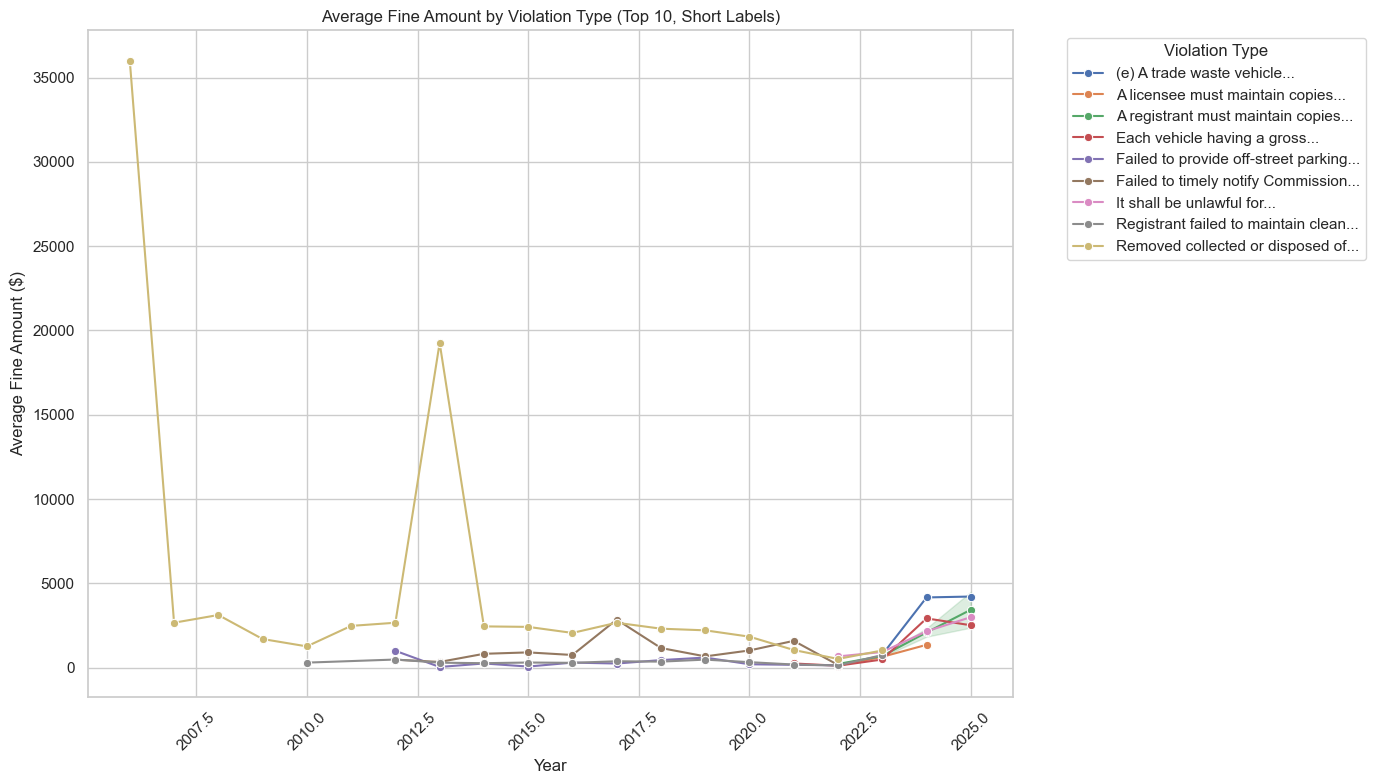

In [25]:
violations_df['Issued Date'] = pd.to_datetime(violations_df['DATE VIOLATION ISSUED'], errors='coerce')
violations_df['Year'] = violations_df['Issued Date'].dt.year

# Get top 10 most frequent violation types
top_violation_types = (
    violations_df['DESCRIPTION OF RULE']
    .value_counts()
    .head(10)
    .index
)

# Shorten the violation type labels (first 5 words only)
def shorten(desc):
    return ' '.join(desc.split()[:5]) + '...'

# Create a mapping from long to short descriptions
short_label_map = {desc: shorten(desc) for desc in top_violation_types}

# Compute average fine
violation_avg_fine = (
    violations_df
    .groupby(['DESCRIPTION OF RULE', 'Year'])['FINE AMOUNT']
    .mean()
    .reset_index()
    .dropna()
)

# Filter to top 10 and replace long labels
violation_avg_fine_top = violation_avg_fine[
    violation_avg_fine['DESCRIPTION OF RULE'].isin(top_violation_types)
].copy()
violation_avg_fine_top['Label'] = violation_avg_fine_top['DESCRIPTION OF RULE'].map(short_label_map)

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=violation_avg_fine_top,
    x='Year',
    y='FINE AMOUNT',
    hue='Label',
    marker='o'
)
plt.title("Average Fine Amount by Violation Type (Top 10, Short Labels)")
plt.xlabel("Year")
plt.ylabel("Average Fine Amount ($)")
plt.xticks(rotation=45)
plt.legend(title='Violation Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/t1/030kx8pn0gvf37kb0sgdpk0r0000gp/T/ipykernel_85557/107385837.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violation_avg_fine_top['Label'] = violation_avg_fine_top['DESCRIPTION OF RULE'].map(short_label_map)


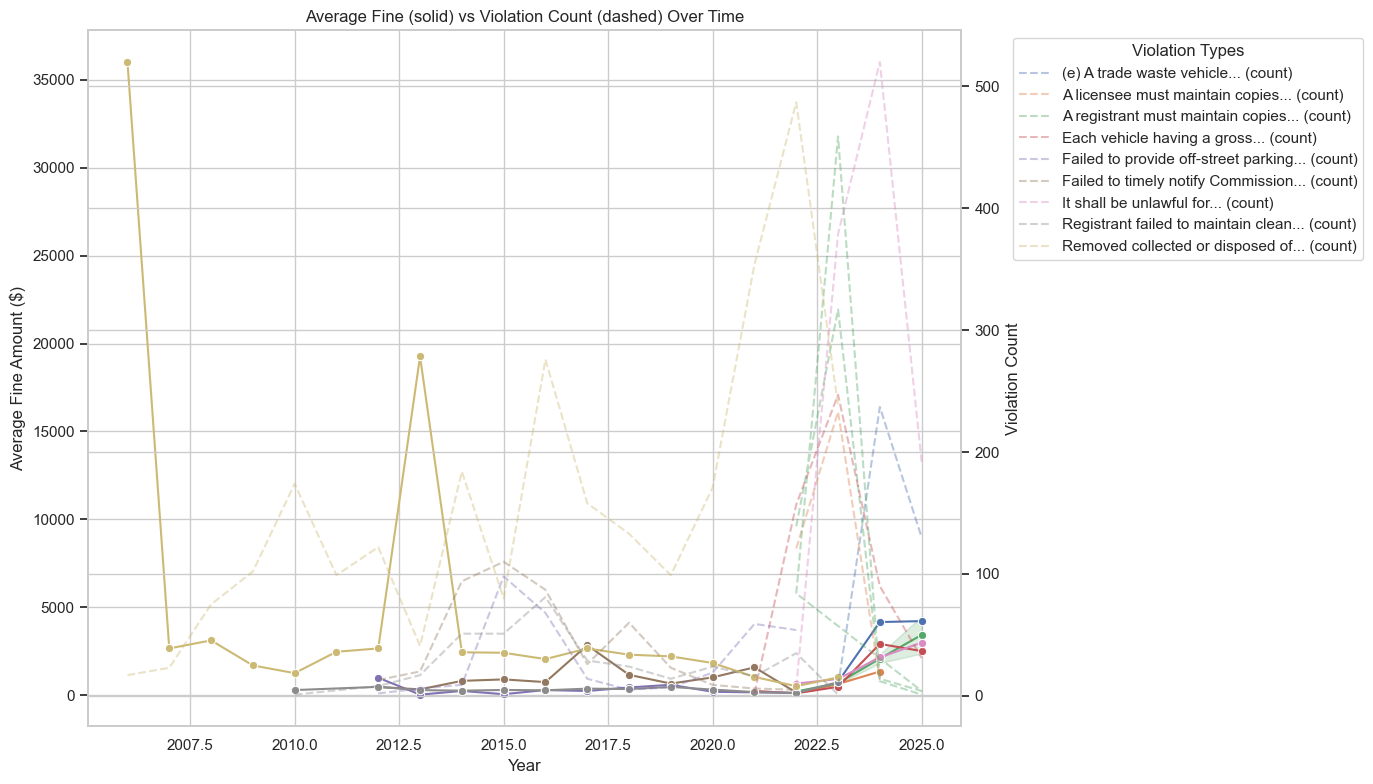

In [26]:
violations_df['Issued Date'] = pd.to_datetime(violations_df['DATE VIOLATION ISSUED'], errors='coerce')
violations_df['Year'] = violations_df['Issued Date'].dt.year

# Top 10 violation types
top_violation_types = violations_df['DESCRIPTION OF RULE'].value_counts().head(10).index
short_label_map = {desc: ' '.join(desc.split()[:5]) + '...' for desc in top_violation_types}

# Average fine
violation_avg_fine = (
    violations_df
    .groupby(['DESCRIPTION OF RULE', 'Year'])['FINE AMOUNT']
    .mean()
    .reset_index()
    .dropna()
)
violation_avg_fine_top = violation_avg_fine[violation_avg_fine['DESCRIPTION OF RULE'].isin(top_violation_types)]
violation_avg_fine_top['Label'] = violation_avg_fine_top['DESCRIPTION OF RULE'].map(short_label_map)

# Violation counts
violation_counts = (
    violations_df
    .groupby(['DESCRIPTION OF RULE', 'Year'])
    .size()
    .reset_index(name='Violation Count')
)

# Merge with counts
violation_combined = pd.merge(
    violation_avg_fine_top,
    violation_counts,
    on=['DESCRIPTION OF RULE', 'Year'],
    how='left'
)

# Re-add labels after merge
violation_combined['Label'] = violation_combined['DESCRIPTION OF RULE'].map(short_label_map)

# Plot
plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=violation_combined,
    x='Year',
    y='FINE AMOUNT',
    hue='Label',
    marker='o',
    legend=False
)

# Secondary axis for count
ax2 = ax.twinx()
for label in violation_combined['Label'].unique():
    subset = violation_combined[violation_combined['Label'] == label]
    ax2.plot(subset['Year'], subset['Violation Count'], linestyle='--', label=label + " (count)", alpha=0.4)

# Labels
ax.set_title("Average Fine (solid) vs Violation Count (dashed) Over Time")
ax.set_ylabel("Average Fine Amount ($)")
ax2.set_ylabel("Violation Count")
ax.set_xlabel("Year")
plt.xticks(rotation=45)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Violation Types")
plt.tight_layout()
plt.show()

In [32]:
# Prep violation data
violations_df['Issued Date'] = pd.to_datetime(violations_df['DATE VIOLATION ISSUED'], errors='coerce')
violations_df['Year'] = violations_df['Issued Date'].dt.year
top_violation_types = violations_df['DESCRIPTION OF RULE'].value_counts().head(10).index
short_label_map = {desc: ' '.join(desc.split()[:5]) + '...' for desc in top_violation_types}

# Average fine
violation_avg_fine = (
    violations_df
    .groupby(['DESCRIPTION OF RULE', 'Year'])['FINE AMOUNT']
    .mean()
    .reset_index()
    .dropna()
)
violation_avg_fine_top = violation_avg_fine[violation_avg_fine['DESCRIPTION OF RULE'].isin(top_violation_types)]
violation_avg_fine_top['Label'] = violation_avg_fine_top['DESCRIPTION OF RULE'].map(short_label_map)

# Violation counts
violation_counts = (
    violations_df
    .groupby(['DESCRIPTION OF RULE', 'Year'])
    .size()
    .reset_index(name='Violation Count')
)

# Merge violation data
violation_combined = pd.merge(
    violation_avg_fine_top,
    violation_counts,
    on=['DESCRIPTION OF RULE', 'Year'],
    how='left'
)
violation_combined['Label'] = violation_combined['DESCRIPTION OF RULE'].map(short_label_map)

# Complaints data
complaints_df['Reported Date'] = pd.to_datetime(complaints_df['DATE COMPLAINT/INQUIRY REPORTED ON'], errors='coerce')
complaints_df['Year'] = complaints_df['Reported Date'].dt.year
complaint_counts_yearly = complaints_df.groupby('Year').size().reset_index(name='Complaint Count')

# Yearly summary for correlation
violation_totals = violations_df.groupby('Year').size().reset_index(name='Violation Count')
fine_totals = violations_df.groupby('Year')['FINE AMOUNT'].sum().reset_index(name='Total Fine')
yearly_summary = pd.merge(violation_totals, fine_totals, on='Year', how='outer')
yearly_summary = pd.merge(yearly_summary, complaint_counts_yearly, on='Year', how='outer')
correlation_matrix = yearly_summary.corr()

# --- Plot ---
fig = go.Figure()

# Avg Fine (solid lines)
for label in violation_combined['Label'].unique():
    subset = violation_combined[violation_combined['Label'] == label]
    fig.add_trace(go.Scatter(
        x=subset['Year'],
        y=subset['FINE AMOUNT'],
        name=f"{label} - Avg Fine",
        mode='lines+markers',
        yaxis="y1"
    ))

# Violation count (dashed)
for label in violation_combined['Label'].unique():
    subset = violation_combined[violation_combined['Label'] == label]
    fig.add_trace(go.Scatter(
        x=subset['Year'],
        y=subset['Violation Count'],
        name=f"{label} - Violations",
        mode='lines',
        line=dict(dash='dash'),
        yaxis="y2",
        showlegend=False
    ))

# Total Complaints (orange)
fig.add_trace(go.Scatter(
    x=complaint_counts_yearly['Year'],
    y=complaint_counts_yearly['Complaint Count'],
    name='Total Complaints',
    line=dict(color='orange', width=3),
    yaxis="y3"
))

fig.update_layout(
    title="Avg Fine (solid), Violations (dashed), and Total Complaints (orange) Over Time",
    xaxis=dict(title='Year'),
    yaxis=dict(title="Avg Fine ($)", side='left'),
    yaxis2=dict(title="Violation Count", overlaying='y', side='right'),
    yaxis3=dict(title="Total Complaints", anchor='free', overlaying='y', side='right', position=.85),
    legend=dict(x=1.05, y=1),
    width=1200,
    height=600
)

fig.show()
print("Correlation Matrix:")
print(correlation_matrix)

/var/folders/t1/030kx8pn0gvf37kb0sgdpk0r0000gp/T/ipykernel_85557/493915801.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Correlation Matrix:
                     Year  Violation Count  Total Fine  Complaint Count
Year             1.000000         0.781887    0.683688         0.346982
Violation Count  0.781887         1.000000    0.924397         0.205646
Total Fine       0.683688         0.924397    1.000000         0.038520
Complaint Count  0.346982         0.205646    0.038520         1.000000


/var/folders/t1/030kx8pn0gvf37kb0sgdpk0r0000gp/T/ipykernel_85557/739707616.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/t1/030kx8pn0gvf37kb0sgdpk0r0000gp/T/ipykernel_85557/739707616.py:35: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



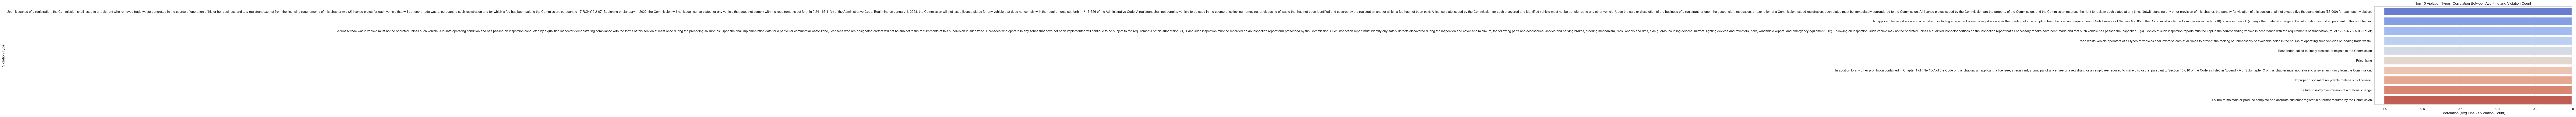

In [34]:
# Prepare yearly violation data
violations_df['Year'] = pd.to_datetime(violations_df['DATE VIOLATION ISSUED'], errors='coerce').dt.year

violation_correlation_df = (
    violations_df.dropna(subset=['DESCRIPTION OF RULE', 'FINE AMOUNT', 'Year'])
    .groupby(['DESCRIPTION OF RULE', 'Year'])
    .agg(
        TotalFines=('FINE AMOUNT', 'sum'),
        ViolationCount=('FINE AMOUNT', 'count'),
        AvgFine=('FINE AMOUNT', 'mean')
    )
    .reset_index()
)

# Compute correlation between AvgFine and ViolationCount for each rule
correlation_by_rule = (
    violation_correlation_df
    .groupby('DESCRIPTION OF RULE')[['AvgFine', 'ViolationCount']]
    .corr()
    .iloc[0::2, -1]  # keep only AvgFine vs ViolationCount
    .reset_index()
    .rename(columns={'DESCRIPTION OF RULE': 'Violation Type', 'ViolationCount': 'Correlation'})
    .drop(columns=['level_1'])
    .sort_values(by='Correlation')
)

# Filter top 10 most negative correlations
top_negative_corr = correlation_by_rule.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_negative_corr, x='Correlation', y='Violation Type', palette='coolwarm')
plt.title("Top 10 Violation Types: Correlation Between Avg Fine and Violation Count")
plt.xlabel("Correlation (Avg Fine vs Violation Count)")
plt.ylabel("Violation Type")
plt.tight_layout()
plt.show()

In [37]:
import plotly.express as px

# Aggregate by rule and year
violation_correlation_df = (
    violations_df.dropna(subset=['DESCRIPTION OF RULE', 'FINE AMOUNT', 'Year'])
    .groupby(['DESCRIPTION OF RULE', 'Year'])
    .agg(
        TotalFines=('FINE AMOUNT', 'sum'),
        ViolationCount=('FINE AMOUNT', 'count'),
        AvgFine=('FINE AMOUNT', 'mean')
    )
    .reset_index()
)

# Filter violation types with at least 5 years of data
valid_rule_counts = violation_correlation_df.groupby('DESCRIPTION OF RULE')['Year'].nunique()
valid_rules = valid_rule_counts[valid_rule_counts >= 5].index
filtered_df = violation_correlation_df[violation_correlation_df['DESCRIPTION OF RULE'].isin(valid_rules)]

# Compute correlation
filtered_corr = (
    filtered_df
    .groupby('DESCRIPTION OF RULE')[['AvgFine', 'ViolationCount']]
    .corr()
    .iloc[0::2, -1]  # correlation between AvgFine and ViolationCount
    .reset_index()
    .rename(columns={'DESCRIPTION OF RULE': 'Violation Type', 'ViolationCount': 'Correlation'})
    .drop(columns=['level_1'])
)

# Shorten labels
filtered_corr['Violation Type Short'] = filtered_corr['Violation Type'].str.slice(0, 50) + '...'

# Top 10 with strongest negative correlation
top_negative_corr = filtered_corr.sort_values(by='Correlation').head(10)

# Plot
fig = px.bar(
    top_negative_corr,
    x='Correlation',
    y='Violation Type Short',
    orientation='h',
    color='Correlation',
    color_continuous_scale='RdBu',
    title="Top 10 Violation Types: Correlation Between Avg Fine and Violation Count (Interactive)",
    hover_data={'Violation Type': True, 'Correlation': ':.2f', 'Violation Type Short': False}
)

fig.update_layout(
    xaxis_title="Correlation (Avg Fine vs Violation Count)",
    yaxis_title="Violation Type",
    coloraxis_colorbar=dict(title="Correlation"),
    height=600
)

fig.show()

In [39]:
complaints_df['DATE COMPLAINT/INQUIRY REPORTED ON'] = pd.to_datetime(complaints_df['DATE COMPLAINT/INQUIRY REPORTED ON'], errors='coerce')
violations_df['DATE VIOLATION ISSUED'] = pd.to_datetime(violations_df['DATE VIOLATION ISSUED'], errors='coerce')
complaints_df['Year'] = complaints_df['DATE COMPLAINT/INQUIRY REPORTED ON'].dt.year
violations_df['Year'] = violations_df['DATE VIOLATION ISSUED'].dt.year

# Count complaints and violations per account per year
complaint_counts = complaints_df.groupby(['ACCOUNT NAME', 'Year']).size().reset_index(name='Complaints')
violation_counts = violations_df.groupby(['ACCOUNT NAME', 'Year']).size().reset_index(name='Violations')

# Merge them
merged_counts = pd.merge(complaint_counts, violation_counts, on=['ACCOUNT NAME', 'Year'], how='outer').fillna(0)

# Filter accounts with data for at least 5 years
valid_accounts = merged_counts.groupby('ACCOUNT NAME')['Year'].nunique()
valid_accounts = valid_accounts[valid_accounts >= 5].index
filtered = merged_counts[merged_counts['ACCOUNT NAME'].isin(valid_accounts)]

# Compute correlation
correlations = (
    filtered.groupby('ACCOUNT NAME')[['Complaints', 'Violations']]
    .corr()
    .iloc[0::2, -1]
    .reset_index()
    .rename(columns={'ACCOUNT NAME': 'Account Name', 'Violations': 'Correlation'})
    .drop(columns=['level_1'])
)

# Add short labels
correlations['Account Name Short'] = correlations['Account Name'].str.slice(0, 50) + '...'

# Plot top 10 with strongest correlation
top_corr = correlations.sort_values(by='Correlation', ascending=False).head(10)

fig = px.bar(
    top_corr,
    x='Correlation',
    y='Account Name Short',
    orientation='h',
    color='Correlation',
    color_continuous_scale='Viridis',
    title="Top 10 Accounts: Correlation Between Complaints and Violations Over Time",
    hover_data={'Account Name': True, 'Correlation': ':.2f', 'Account Name Short': False}
)

fig.update_layout(
    xaxis_title="Correlation (Complaints vs Violations)",
    yaxis_title="Account Name",
    coloraxis_colorbar=dict(title="Correlation"),
    height=600
)

fig.show()

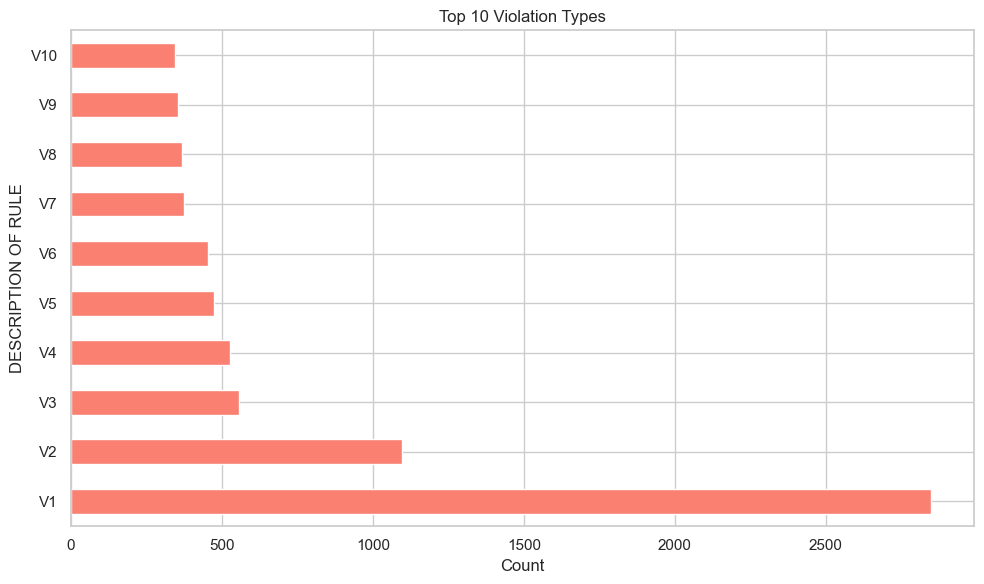

V1: Removed collected or disposed of trade waste or without the proper Commission issued license or exemption from licensing requirements
V2: It shall be unlawful for any person to operate a business for the purpose of the collection of trade waste from the premises of a commercial establishment required to provide for the removal of such waste pursuant to the provisions of section 16-116 of this code, or the removal or disposal of trade waste from such premises, or to engage in, conduct or cause the operation of such a business, without having first obtained a license therefor from the commission pursuant to the provisions of this chapter. Notwithstanding the provisions of this subdivision, a business solely engaged in the removal of waste materials resulting from building demolition, construction, alteration or excavation shall be exempt from the licensing provisions of this subdivision where, except in regard to the principals of a business solely in either or both of the class seve

In [6]:
# Create mapping
violation_labels = {v: f"V{i+1}" for i, v in enumerate(violation_types.index)}
renamed = violation_types.rename(index=violation_labels)

# Plot and legend
fig, ax = plt.subplots(figsize=(10, 6))
renamed.plot(kind='barh', color='salmon')
plt.title("Top 10 Violation Types")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# Print full label map
for code, full in violation_labels.items():
    print(f"{full}: {code}")

## Repeat Offenders

/var/folders/t1/030kx8pn0gvf37kb0sgdpk0r0000gp/T/ipykernel_80332/1688635635.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_accounts.values, y=top_accounts.index, palette='Reds_r')


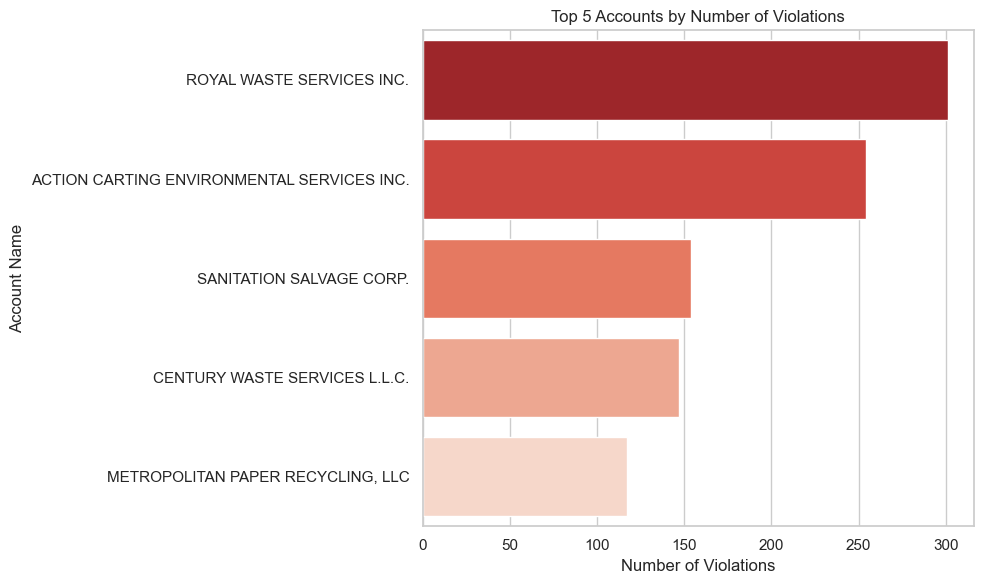

In [2]:
# Top 5 accounts with most violations
top_accounts = violations_df['ACCOUNT NAME'].value_counts().head(5)

# Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_accounts.values, y=top_accounts.index, palette='Reds_r')
plt.title("Top 5 Accounts by Number of Violations")
plt.xlabel("Number of Violations")
plt.ylabel("Account Name")
plt.tight_layout()
plt.show()

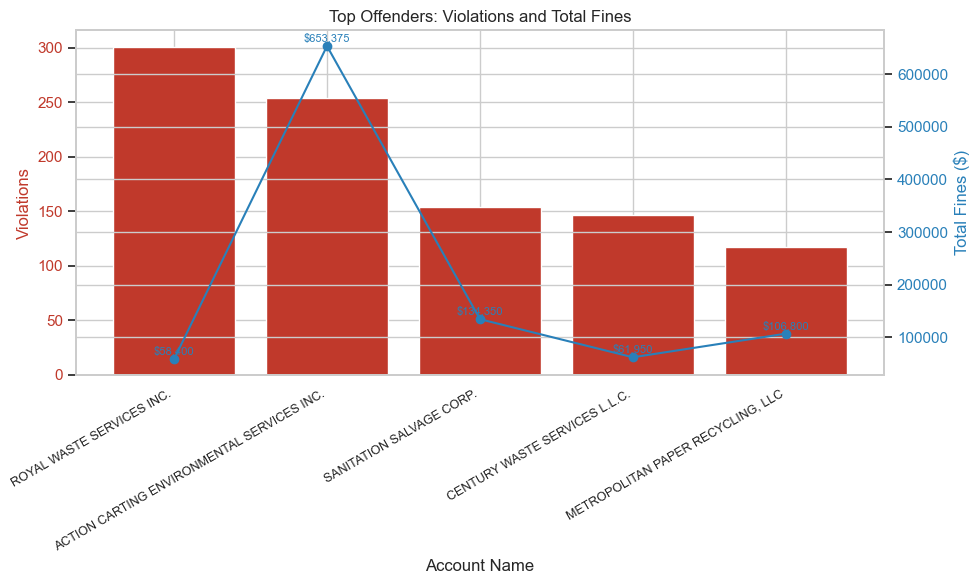

In [8]:
# Extract top 5 accounts
top_accounts = violations_df['ACCOUNT NAME'].value_counts().head(5)
top_fines = violations_df[violations_df['ACCOUNT NAME'].isin(top_accounts.index)]
fine_totals = top_fines.groupby('ACCOUNT NAME')['FINE AMOUNT'].sum()
fine_totals = fine_totals.reindex(top_accounts.index)  # ensure matching order

# Create the figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for violations
color = '#c0392b'
ax1.bar(top_accounts.index, top_accounts.values, color=color, label='Violations')
ax1.set_ylabel('Violations', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel("Account Name")
ax1.set_title("Top Offenders: Violations and Total Fines")

# Rotate x labels
plt.xticks(rotation=30, ha='right', fontsize=9)

# Line chart for fines
ax2 = ax1.twinx()
color = '#2980b9'
ax2.plot(top_accounts.index, fine_totals.values, color=color, marker='o', label='Total Fines')
ax2.set_ylabel('Total Fines ($)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Optional: Add data labels to points
for i, val in enumerate(fine_totals.values):
    ax2.text(i, val + 5000, f"${int(val):,}", ha='center', va='bottom', fontsize=8, color=color)

plt.tight_layout()
plt.show()

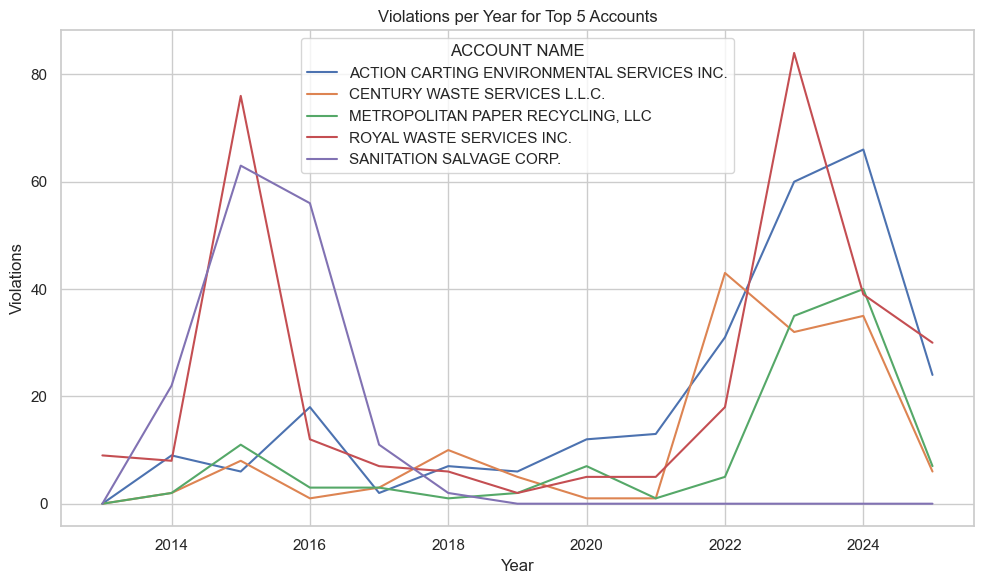

In [16]:
violations_df['Year'] = pd.to_datetime(violations_df['DATE VIOLATION ISSUED'], errors='coerce').dt.year
top_violators = top_accounts.index.tolist()

trend = violations_df[violations_df['ACCOUNT NAME'].isin(top_violators)]
trend = trend.groupby(['ACCOUNT NAME', 'Year']).size().unstack().fillna(0).T

trend.plot(kind='line', figsize=(10, 6))
plt.title("Violations per Year for Top 5 Accounts")
plt.xlabel("Year")
plt.ylabel("Violations")
plt.tight_layout()
plt.show()

/var/folders/t1/030kx8pn0gvf37kb0sgdpk0r0000gp/T/ipykernel_80332/2311440675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_trend['Quarter'] = monthly_trend['Month'].dt.to_timestamp().dt.to_period("Q").dt.to_timestamp()


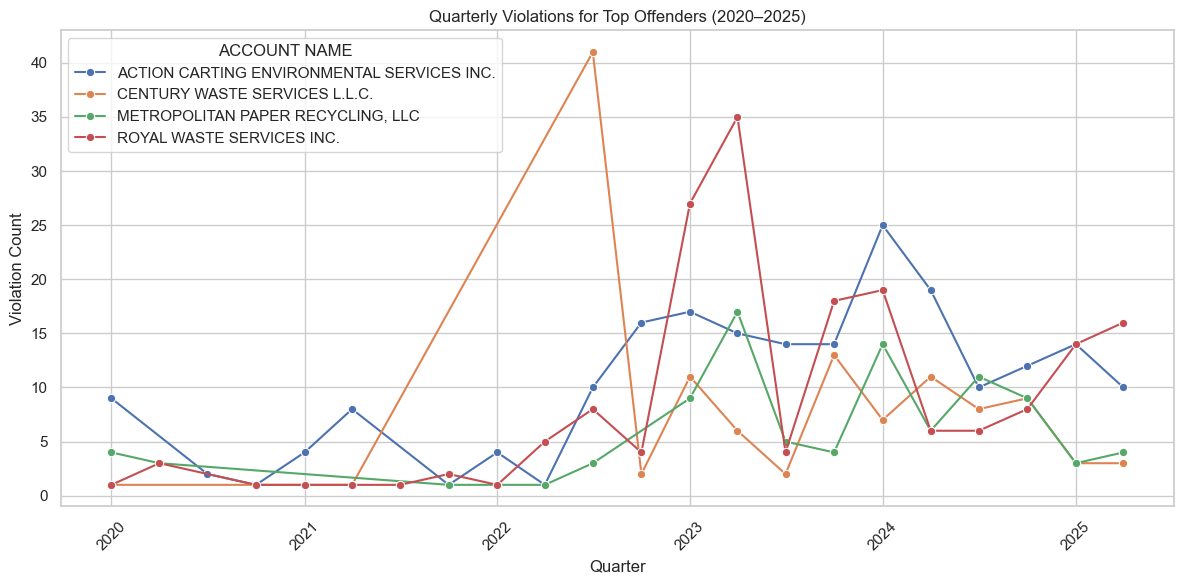

In [26]:
# Convert violation dates to quarterly
monthly_trend['Quarter'] = monthly_trend['Month'].dt.to_timestamp().dt.to_period("Q").dt.to_timestamp()

# Filter to recent quarters (e.g. 2020 and after)
recent_quarters = monthly_trend[monthly_trend['Quarter'] >= '2020-01-01']

# Group by account and quarter
quarterly_counts = (
    recent_quarters.groupby(['ACCOUNT NAME', 'Quarter'])
    .size()
    .reset_index(name='Violation Count')
)

# Optional: rolling average for smoothing (uncomment to use)
quarterly_counts['Smoothed'] = (
     quarterly_counts.groupby('ACCOUNT NAME')['Violation Count']
     .transform(lambda x: x.rolling(window=2, min_periods=1).mean())
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=quarterly_counts, x='Quarter', y='Violation Count', hue='ACCOUNT NAME', marker='o')

# Optional: add a policy marker
#plt.axvline(pd.to_datetime('2023-01-01'), color='gray', linestyle='--', label='2023 Policy Marker')

plt.xticks(rotation=45)
plt.title("Quarterly Violations for Top Offenders (2020–2025)")
plt.xlabel("Quarter")
plt.ylabel("Violation Count")
plt.legend(title='ACCOUNT NAME')
plt.tight_layout()
plt.show()

/var/folders/t1/030kx8pn0gvf37kb0sgdpk0r0000gp/T/ipykernel_80332/1013668497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_trend['Quarter'] = monthly_trend['Month'].dt.to_timestamp().dt.to_period("Q").dt.to_timestamp()


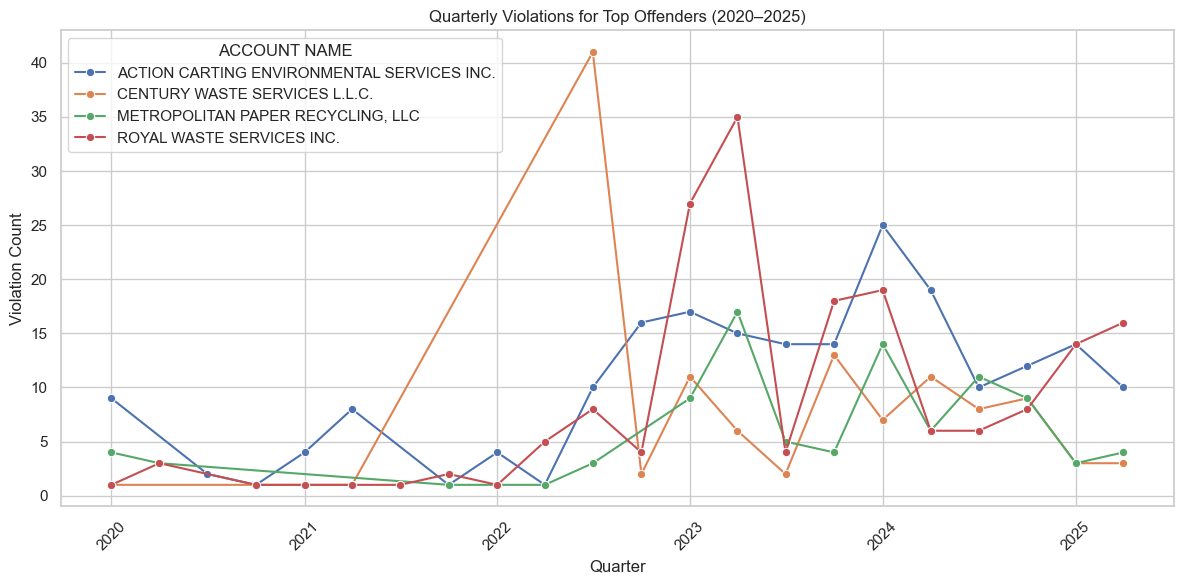

In [27]:
# Convert violation dates to quarterly
monthly_trend['Quarter'] = monthly_trend['Month'].dt.to_timestamp().dt.to_period("Q").dt.to_timestamp()

# Filter to recent quarters (e.g. 2020 and after)
recent_quarters = monthly_trend[monthly_trend['Quarter'] >= '2020-01-01']

# Group by account and quarter
quarterly_counts = (
    recent_quarters.groupby(['ACCOUNT NAME', 'Quarter'])
    .size()
    .reset_index(name='Violation Count')
)

# Optional: rolling average for smoothing (uncomment to use)
#quarterly_counts['Smoothed'] = (
#     quarterly_counts.groupby('ACCOUNT NAME')['Violation Count']
 #    .transform(lambda x: x.rolling(window=2, min_periods=1).mean())
#)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=quarterly_counts, x='Quarter', y='Violation Count', hue='ACCOUNT NAME', marker='o')

# Optional: add a policy marker
#plt.axvline(pd.to_datetime('2023-01-01'), color='gray', linestyle='--', label='2023 Policy Marker')

plt.xticks(rotation=45)
plt.title("Quarterly Violations for Top Offenders (2020–2025)")
plt.xlabel("Quarter")
plt.ylabel("Violation Count")
plt.legend(title='ACCOUNT NAME')
plt.tight_layout()
plt.show()